In [18]:
import sys
from pathlib import Path

import cartopy.crs as ccrs
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

sys.path.insert(0, '/home/users/mmuetz/deploy/wcrp_hackathon/scripts/process_um_data')
import um_latlon_pp_to_healpix_nc as um2hp
import um_process_tasks as umpt

In [4]:
def fix_coords(ds, lat_dim="lat", lon_dim="lon"):
    # Find where longitude crosses from negative to positive (approx. where lon=0)
    lon_0_index = (ds[lon_dim] < 0).sum().item()
    
    # Create indexers for the roll
    lon_indices = np.roll(np.arange(ds.sizes[lon_dim]), -lon_0_index)
    
    # Roll dataset and convert longitudes to 0-360 range
    ds = ds.isel({lon_dim: lon_indices})
    lon360 = xr.where(ds[lon_dim] < 0, ds[lon_dim] + 360, ds[lon_dim])
    ds = ds.assign_coords({lon_dim: lon360})
    
    # Ensure latitude and longitude are in ascending order if needed
    if np.all(np.diff(ds[lat_dim].values) < 0):
        ds = ds.isel({lat_dim: slice(None, None, -1)})
    if np.all(np.diff(ds[lon_dim].values) < 0):
        ds = ds.isel({lon_dim: slice(None, None, -1)})
    
    return ds


In [7]:
ds = xr.open_mfdataset('/gws/nopw/j04/hrcm/mmuetz/obs/IMERGv7/merg_20190801??_10km-pixel.nc').pipe(fix_coords)

In [29]:
z = 10

In [30]:
weights_path = Path('/gws/nopw/j04/hrcm/mmuetz/weights/') / umpt.weights_filename(ds, z, 'lon', 'lat', True, True)
weights_path

PosixPath('/gws/nopw/j04/hrcm/mmuetz/weights/regrid_weights.hpz10.cyclic_lon=True.regional=True.lon=(0.050,359.950,3600).lat=(-59.950,59.950,1200).nc')

In [31]:
if not weights_path.exists():
    um2hp.gen_weights(ds.precipitation, z, 'lon', 'lat', True, weights_path, True)

2025-04-30 11:32:26.047 | DEBUG    | um_latlon_pp_to_healpix_nc:gen_weights:106 - adding cyclic column
2025-04-30 11:32:29.285 | DEBUG    | um_latlon_pp_to_healpix_nc:gen_weights:117 - # icell: 10890310
2025-04-30 11:32:29.837 | INFO     | um_latlon_pp_to_healpix_nc:gen_weights:132 - computing weights
2025-04-30 11:33:51.650 | DEBUG    | um_latlon_pp_to_healpix_nc:gen_weights:134 - <xarray.Dataset> Size: 403MB
Dimensions:  (tgt_idx: 10890310, tri: 3)
Dimensions without coordinates: tgt_idx, tri
Data variables:
    src_idx  (tgt_idx, tri) int32 131MB 539399 540600 539400 ... 3780600 3779399
    weights  (tgt_idx, tri) float64 261MB 0.127 0.5 0.373 ... 0.373 0.127 0.5
    valid    (tgt_idx) bool 11MB True True True True ... True True True True
2025-04-30 11:33:53.210 | INFO     | um_latlon_pp_to_healpix_nc:gen_weights:136 - saved weights to /gws/nopw/j04/hrcm/mmuetz/weights/regrid_weights.hpz10.cyclic_lon=True.regional=True.lon=(0.050,359.950,3600).lat=(-59.950,59.950,1200).nc


In [34]:
regridder = um2hp.UMLatLon2HealpixRegridder(zoom_level=z, add_cyclic=True, weights_path=weights_path, regional=True, regional_chunks=4**9)

In [35]:
da_precip_hp = regridder.regrid(ds.precipitation, 'lon', 'lat')

2025-04-30 11:34:29.416 | DEBUG    | um_latlon_pp_to_healpix_nc:_regrid_easygems_delaunay:220 - # icell: 10890310
2025-04-30 11:34:29.416 | DEBUG    | um_latlon_pp_to_healpix_nc:_regrid_easygems_delaunay:221 - # ichunk: 12582912


<Figure size 640x480 with 0 Axes>

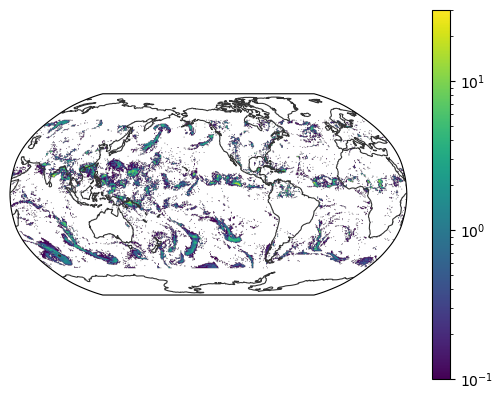

In [40]:
crs = xr.DataArray(
    name="crs",
    attrs={
        "grid_mapping_name": "healpix",
        "healpix_nside": 2 ** z,
        "healpix_order": "nest",
    },
)


im = egh.healpix_show(da_precip_hp.isel(time=0).assign_coords(crs=crs), norm=mpl.colors.LogNorm(vmin=10e-2, vmax=30))
plt.colorbar(im);

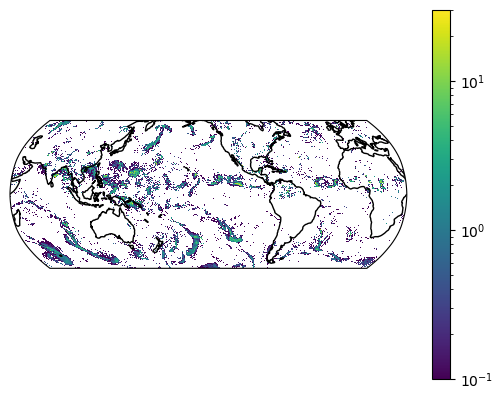

In [41]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=-137)})
im = ax.pcolormesh(ds.lon, ds.lat, ds.precipitation.isel(time=0), transform=ccrs.PlateCarree(), norm=mpl.colors.LogNorm(vmin=10e-2, vmax=30))
ax.coastlines()
plt.colorbar(im)